In [297]:
import pandas as pd 
import numpy as np 
from scipy.stats import laplace
from tqdm import tqdm
import matplotlib.pyplot as plt 
plt.style.use('dark_background')

In [772]:
data = pd.read_csv('../data/example_laplace_3.csv')
x,y = np.array(data['x']),np.array(data['y'])

Implement checks

create documentation

In [848]:
ldm = AsymmetricLaplaceDistributionModel()

100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


True

In [849]:
ldm.params()

{'loc': 425.93185223418,
 'std': 5.911265359962872,
 'height': 0.035231410125526184,
 'kappa': 1.0931647011444823}

In [850]:
#ldm.set_params({'kappa':1.1,'loc':426,'height':0.03500766869357141,'std':5.960049805511074})

In [851]:
pred = ldm.predict(x)

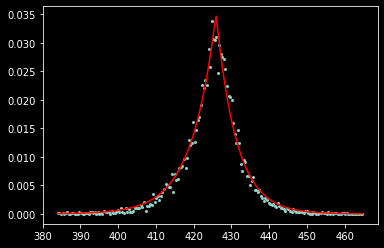

In [852]:
plt.scatter(x,y,s=4)
plt.plot(x,pred,c='r')

Do gradient descent on a single parameter for n steps, switch between steps, do this process m times

In [811]:
import numpy as np
import pandas as pd
from scipy.stats import laplace_asymmetric
from tqdm import tqdm


class AsymmetricLaplaceDistributionModel:
    def __init__(self,size=1,decay=0.9,resolution=100,depth=4,verbose=True):
        """
        Parameters:
            <optimize_fit> (bool): Determines whether a local grid search is performed around the intial estimated parameters. Recommended for higher accuracy, but does take longer.

        """
        self.__size = size
        self.__decay = decay 
        self.__resolution = resolution
        self.__depth = depth
        self.__verbose = verbose

    def estimate_height(self,yl):
        y_max_index = yl.index(max(yl))
        return yl[y_max_index]

    def estimate_loc(self,xl,yl):
        loc = xl[yl.index(max(yl))]
        return loc

    def estimate_std(self,xa,ya):
        sums = []
        for i in range(len(ya)):
            sums.append(ya[:i].sum()/ya.sum())
        sums = np.array(sums)
        subset = sums[(sums>0.25) & (sums<0.75)]
        subset = list(subset)
        sums = list(sums)
        s,e = sums.index(subset[0]),sums.index(subset[-1])
        est_std = xa[e] - xa[s]
        return est_std

    def ols(self,pred,true):
        return ((true - pred)**2).sum()

    def param_range(self,param,size,resolution):
        prange = np.linspace(param-(param*size),param+(param*size),resolution)
        return prange[prange>0]

    def set_opt_param(self,param,x,y,param_range):
        resid = []
        for i in param_range:
            self.set_params({param:i})
            resid.append(self.ols(self.predict(x),y))
        opt = param_range[resid.index(min(resid))]
        self.set_params({param:opt})


    def __layer_grid_search(self,x,y,size):
        loc_range = self.param_range(self.params()['loc'],size,self.__resolution)
        self.set_opt_param('loc',x,y,loc_range)

        std_range = self.param_range(self.params()['std'],size,self.__resolution)
        self.set_opt_param('std',x,y,std_range)

        height_range = self.param_range(self.params()['height'],size,self.__resolution)
        self.set_opt_param('height',x,y,height_range)

        kappa_range = self.param_range(self.params()['kappa'],size,self.__resolution)
        self.set_opt_param('kappa',x,y,kappa_range)

    def __grid_search(self,x,y):
        usize = self.__size
        for i in tqdm(range(self.__depth),disable=not self.__verbose):
            self.__layer_grid_search(x,y,usize)
            usize = usize * self.__decay

    def __get_params(self,x,y):
        xa,ya,xl,yl = np.array(x),np.array(y),list(x),list(y)
        std,height,loc,kappa = self.estimate_std(xa,ya),self.estimate_height(yl),self.estimate_loc(xl,yl),1
        return {'loc':loc,'std':std,'height':height,'kappa':kappa}

    def set_params(self,params):
        for k,v in params.items():
            self.__params[k] = v

    def params(self):
        return self.__params

    def fit(self,x,y):
        data = pd.DataFrame({'x':x,'y':y})
        data = data.sort_values(by='x')
        x,y = data['x'],data['y']
        self.__params = self.__get_params(x,y)
        if self.__grid_search:
            self.__grid_search(x,y)
        return True


    def internal_model(self,x,args):
        loc,std,height,kappa = args['loc'],args['std'],args['height'],args['kappa']
        return laplace_asymmetric.pdf(x,loc=loc,scale=std,kappa=kappa)/((1/std)/(2*height))

    def predict(self,x):
        return self.internal_model(x,self.__params)

    def save(self,x):
        pass

    def load(self,x):
        pass


In [605]:
from scipy.stats import laplace_asymmetric
import matplotlib.pyplot as plt


In [606]:
kappa = 2
mean, var, skew, kurt = laplace_asymmetric.stats(kappa, moments='mvsk')

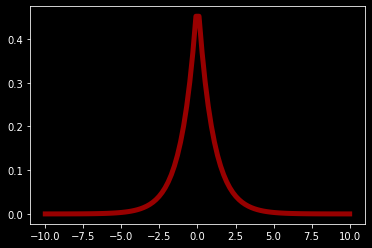

In [616]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(-10,10, 100)
ax.plot(x, laplace_asymmetric.pdf(x, kappa=1),
       'r-', lw=5, alpha=0.6, label='laplace_asymmetric pdf')